In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import os

from nn_models.lstm_unet import UNet_ConvLSTM
from nn_models.NN_model_orig import *

from utils.utilities import *
import torchvision

#generating data
from utils.MB_simulator_utils_v4 import *

# metrics 
from torchmetrics.classification import BinaryF1Score
from torchmetrics.classification import BinaryConfusionMatrix
from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics.classification import BinaryPrecision
from torchmetrics.classification import BinaryRecall


In [16]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print("Using device", device)
path = r'./' # Path to model

tmp_result_dir_exist = os.path.exists("./tmp_results")
if not tmp_result_dir_exist:
   # Create a tmp_results dir because it does not exist
   os.makedirs("./tmp_results")

Using device cuda:0


## Testing model and results

In [21]:
method = 'DeepSMV'  # options : DeepSMV / DBlink / Reg_Unet

if method == 'DBlink':
    
    # model parameters
    model_name = 'DBlink_model'
    img_size = 128 
    num_layers = 2 # The number of LSTM layers
    hidden_channels = 4 # The hidden layer number of channels at the output of each lstm cell. Purpose?: adding more combinations of features? -> Higher complexity. It's more features.
    window_size = 25 # The number of used windows (in each direction) for the inference of each reconstructed frame
    model = ConvOverlapBLSTM(input_size=(img_size, img_size), input_channels=1, hidden_channels=hidden_channels, num_layers=num_layers, device=device).to(device)  #DBlink
     
        
elif method == "DeepSMV":
    
    # model parameters
    model_name = 'DeepSMV_model' 
    num_lstm_layers = 1 
    in_ch = 1  
    out_ch = 1 

    #model = UNet_ConvLSTM(n_channels=1, n_classes=1, use_LSTM=True, parallel_encoder=False, lstm_layers=1).to(device)  #DeepSMV original 
    model = UNet_ConvLSTM(n_channels= in_ch, n_classes= out_ch, use_LSTM=True, parallel_encoder=False, lstm_layers= num_lstm_layers).to(device)  #DeepSMV original 
    
    
elif method == 'Reg_Unet':
    
    # model parameters
    model_name = 'Reg_Unet_model' 
    num_lstm_layers = 1 
    in_ch = 2
    out_ch = 1 
    LSTM_used = False

    #model = UNet_ConvLSTM(n_channels=1, n_classes=1, use_LSTM=True, parallel_encoder=False, lstm_layers=1).to(device)  #DeepSMV original 
    model = UNet_ConvLSTM(n_channels= in_ch, n_classes= out_ch, use_LSTM= LSTM_used, parallel_encoder=False, lstm_layers= num_lstm_layers).to(device)  #DeepSMV original 
    
   


model.load_state_dict(torch.load(model_name, map_location=torch.device(device)))




<All keys matched successfully>

In [22]:


X_test = torch.load('X_test')
y_test = torch.load('y_test')

rotate90 = True   
ktimes = 4
if(rotate90):
    X_test = torch.rot90(X_test,k = ktimes, dims = [3, 4])
    y_test = torch.rot90(y_test,k = ktimes, dims = [2, 3])
    
X_test = X_test.to(device)
y_test = y_test.to(device)
    
#model_name = 'best_model'
#model.load_state_dict(torch.load(model_name, map_location=torch.device(device)))

GT = y_test    
model.eval()

with torch.no_grad():
        
    if method == 'DBlink':   
        GT = y_test[:,[4],:] 
        out = model(X_test,torch.flip(X_test, dims=[1]))
        realout = out[:,X_test.shape[1]//2,[0]]
        
        #print(X_test.shape[1]//2)
        
        #print(GT.shape)
        #print(realout.shape)
                      
    elif method =='DeepSMV':
        GT = y_test[:,[4],:]
        realout,_ = model(X_test)
        #realout = realout[:,0,:,:]
    elif method == 'Reg_Unet':
        GT = y_test[:,[4],:] 
        print(GT.shape)
        
        realout,_ = model(y_test[:,[3,1],:])
        print(realout.shape)
        
        
    else:
        print('check method name')    
    #print(out.shape)
    #print(realout.shape)
    #print(y_test.shape)
        
    criterion = nn.MSELoss()
    Metric=criterion(realout,GT) # MSE 
    print('RMSE (mm/s per pixel per frame) : ' ,np.sqrt(Metric.item())) 
    
    # realout = realout.detach().cpu().numpy()
    # GT = GT.detach().cpu().numpy()

    
folder = r'./tmp_results'
        
realout = normalize_images(realout)
#print(realout.shape)
#print(realout.dtype)
GT = normalize_images(GT)
        
tracks = normalize_images(y_test[:,[3],:])
#realout = realout[:,None,:]
#GT = GT[:,None,:]
        
torchvision.utils.save_image(realout, f"{folder}/inference.png")
torchvision.utils.save_image(GT, f"{folder}/GT.png")
torchvision.utils.save_image(tracks, f"{folder}/input.png")

RMSE (mm/s per pixel per frame) :  2.1965632557972805


## Violin plots of models
### RMSE mm/s per pixel 


In [9]:
# Parameters
G =  100000*0.6  #constant gradient pressure Pa/m^-3  #0.5 original
mu = 3.45*10**-3 #dynamic viscosity  Pa*s
imgsize= 128 #pixels in x and y direction
pixelsize = 5*10**-6 # m isotropic pixel size 
rho = 1056 # kg/m^3

N_test = 32
C = 8*10**11 #concentration of MBs/m^2

Hz = 250
Ts = 1/Hz# sample time in s

T_acq = 1 # time of collecting data
N_frames = T_acq / Ts  #number of simulated frames with frequency Hz, same value for videolength 

sumfactor = 1

window_size = N_frames / sumfactor # total window size 
print('total window size :',window_size)

#N_b = 4 # average number of MB passing through the crossection vessel 

# simulating pixel radius range between min and max pixel radius

R_window = [8,22]

RMSE = np.zeros(( R_window[1] - R_window[0]+1 ,N_test))
F1 = np.zeros(( R_window[1] - R_window[0]+1 ,N_test))
FPR = np.zeros(( R_window[1] - R_window[0]+1 ,N_test))
IoU = np.zeros(( R_window[1] - R_window[0]+1 ,N_test))
PREC = np.zeros(( R_window[1] - R_window[0]+1 ,N_test))
RECALL = np.zeros(( R_window[1] - R_window[0]+1 ,N_test))

R = np.arange(R_window[0],R_window[1]+1)

criterion = nn.MSELoss()
#BCM = BinaryConfusionMatrix().to(device)
#BJI = BinaryJaccardIndex().to(device)
BF1 = BinaryF1Score().to(device)
pre = BinaryPrecision().to(device)
rec = BinaryRecall().to(device)


for i in range(len(R)):
    
    X_test, y_test = create_real_data(N_test,G,mu,imgsize,pixelsize,C,Ts,sumfactor,N_frames,R[i],R[i])
    X_test = torch.FloatTensor(X_test).to(device)
    y_test = torch.FloatTensor(y_test).to(device)
    
    GT = y_test    
    model.eval()

    with torch.no_grad():

        if method == 'DBlink':   
            GT = y_test[:,[4],:] 
            out = model(X_test,torch.flip(X_test, dims=[1]))
            realout = out[:,X_test.shape[1]//2,[0]]
            
            del out

            #print(X_test.shape[1]//2)

            #print(GT.shape)
            #print(realout.shape)

        elif method =='DeepSMV':
            GT = y_test[:,[4],:]
            realout,_ = model(X_test)
            #realout = realout[:,0,:,:]
        elif method == 'Reg_Unet':
            GT = y_test[:,[4],:] 
            #print(GT.shape)

            realout,_ = model(y_test[:,[3,1],:])
            #print(realout.shape)
            #realout =y_test[:,[3],:]


        else:
            print('check method name')    
  

        
        dumrealout = torch.zeros_like(GT).to(device)
        threshold = 0.5
        dumrealout[realout>threshold ] =1
        dumrealout[realout<=threshold]= 0
        
        dumGT = torch.zeros_like(GT).to(device)
        dumGT[GT>threshold] = 1
        dumGT[GT<=threshold] = 0
        
        
        for j in range(realout.shape[0]):
            Metric=criterion(realout[j,:],GT[j,:]) # MSE
            RMSE[i,j] =  np.sqrt(Metric.item())
            #bjimetric = BJI(dumrealout[j,:],dumGT[j,:])
            #IoU[i,j] = bjimetric.item()
            
            F1metric = BF1(dumrealout[j,:],dumGT[j,:])
            F1[i,j] = F1metric.item()
            
            #BCMmetric = BCM(dumrealout[j,:],dumGT[j,:])
            #fpr = BCMmetric[0,1] / (BCMmetric[0,1] + BCMmetric[0,0])
            #FPR[i,j] = fpr 
            
            premetric = pre(dumrealout[j,:],dumGT[j,:])
            PREC[i,j] = premetric.item()   
            
            recmetric = rec(dumrealout[j,:],dumGT[j,:])
            RECALL[i,j] = recmetric.item()     
            
        del X_test,y_test,dumGT,dumrealout,Metric,F1metric,GT,realout,premetric,recmetric
        torch.cuda.empty_cache()

            
        


total window size : 250.0


100% 32/32 [00:01<00:00, 30.23it/s]
100% 32/32 [00:01<00:00, 30.19it/s]
100% 32/32 [00:01<00:00, 29.17it/s]
100% 32/32 [00:01<00:00, 28.07it/s]
100% 32/32 [00:01<00:00, 26.30it/s]
100% 32/32 [00:01<00:00, 24.55it/s]
100% 32/32 [00:01<00:00, 22.98it/s]
100% 32/32 [00:01<00:00, 20.40it/s]
100% 32/32 [00:01<00:00, 19.93it/s]
100% 32/32 [00:01<00:00, 19.20it/s]
100% 32/32 [00:01<00:00, 17.31it/s]
100% 32/32 [00:02<00:00, 14.97it/s]
100% 32/32 [00:02<00:00, 13.97it/s]
100% 32/32 [00:02<00:00, 11.94it/s]
100% 32/32 [00:03<00:00, 10.50it/s]


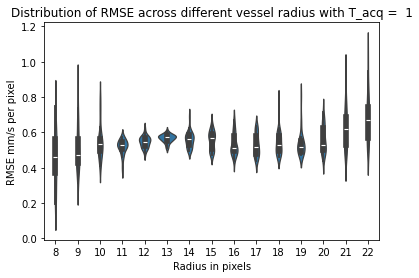

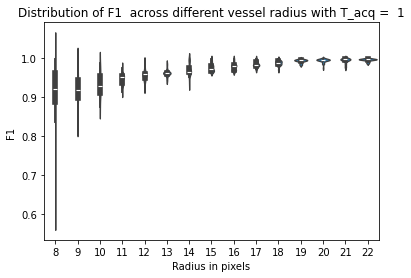

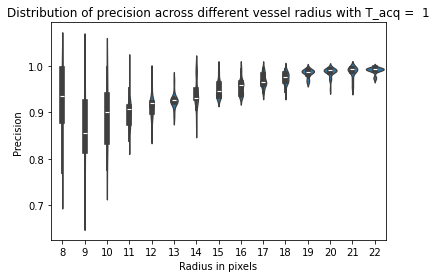

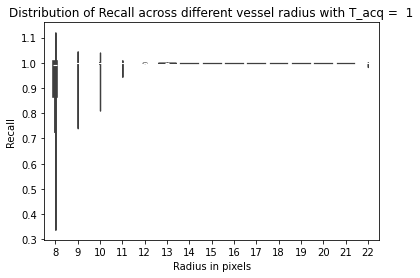

In [10]:
## RMSE

df = pd.DataFrame({
    'Radius in pixels': np.repeat(R, RMSE.shape[1]),
    'RMSE mm/s per pixel': RMSE.ravel()
})


sns.violinplot(x='Radius in pixels', y='RMSE mm/s per pixel', data=df)
plt.title(f'Distribution of RMSE across different vessel radius with T_acq =  {T_acq}')
plt.xlabel('Radius in pixels')
plt.ylabel('RMSE mm/s per pixel')
plt.show()

## F1 or dicecoefficient

dfF1 = pd.DataFrame({
    'Radius': np.repeat(R, F1.shape[1]),
    'F1 ': F1 .ravel()
})

sns.violinplot(x='Radius', y='F1 ', data=dfF1 )
plt.title(f'Distribution of F1  across different vessel radius with T_acq =  {T_acq}')
plt.xlabel('Radius in pixels')
plt.ylabel('F1 ')
plt.show()

## precision

dfPREC = pd.DataFrame({
    'Radius': np.repeat(R, PREC.shape[1]),
    'PREC ': PREC.ravel()
})

sns.violinplot(x='Radius', y='PREC ', data=dfPREC )
plt.title(f'Distribution of precision across different vessel radius with T_acq =  {T_acq}')
plt.xlabel('Radius in pixels')
plt.ylabel('Precision ')
plt.show()

## recall

dfRECALL = pd.DataFrame({
    'Radius': np.repeat(R, RECALL.shape[1]),
    'RECALL': RECALL.ravel()
})

sns.violinplot(x='Radius', y='RECALL', data=dfRECALL )
plt.title(f'Distribution of Recall across different vessel radius with T_acq =  {T_acq}')
plt.xlabel('Radius in pixels')
plt.ylabel('Recall ')
plt.show()

# ## IoU or Jaccard

# dfIoU = pd.DataFrame({
#     'Radius': np.repeat(R, IoU.shape[1]),
#     'IoU': IoU.ravel()
# })

# sns.violinplot(x='Radius', y='IoU', data=dfIoU)
# plt.title(f'Distribution of IoU Across different vessel radius with T_acq =  {T_acq}')
# plt.xlabel('Radius in pixels')
# plt.ylabel('IoU')
# plt.show()

# #Hallucination or FP / (FP + TN)

# dfFPR = pd.DataFrame({
#     'Radius': np.repeat(R, FPR.shape[1]),
#     'FPR': FPR.ravel()
# })

# sns.violinplot(x='Radius', y='FPR', data=dfFPR)
# plt.title(f'Distribution of FPR Across different vessel radius with T_acq =  {T_acq}')
# plt.xlabel('Radius in pixels')
# plt.ylabel('FPR')
# plt.show()



In [7]:
20*1e3/250/5

16.0